In [2]:
# Für sicheres Parsing von JSON-Strings als Python-Literale (Fallback-Parser)
import ast

# Für JSON-Datei-Operationen (Laden der synthetischen Trainingsdaten)
import json

# Für DataFrame-Operationen und Training-Log-Analyse
import pandas as pd

# Für Umgebungsvariablen-Zugriff (Hugging Face Token)
import os

# Für das Unterdrücken von SyntaxWarnings beim JSON-Parsing
import warnings

# Für das Zählen der Label-Verteilung (low/medium/high risk)
from collections import Counter

# Für die Erstellung von Hugging Face Datasets aus Listen
from datasets import Dataset

# Für das Laden von .env-Dateien mit API-Tokens
from dotenv import load_dotenv

# Für moderne Dateipfad-Operationen (Glob-Pattern für JSON-Files)
from pathlib import Path

# Hugging Face Transformers: Model, Training-Config, Trainer und Early Stopping
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

# Für Visualisierung der Training/Validation Loss Kurven
import matplotlib.pyplot as plt

# Für die Tokenisierung der Command-Texte (DeBERTa Tokenizer)
from transformers import AutoTokenizer

# Für dynamisches Padding der Batches während des Trainings
from transformers import DataCollatorWithPadding


load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Laden und aufbereiten der Trainingsdaten

Erstellen der Labeldictionaries

In [51]:
id2label = {0: "low", 1: "medium", 2: "high"}
label2id = {"low": 0, "medium": 1, "high": 2}

trainingsdaten formatieren und codieren

In [52]:
data_list = []
label_counts = Counter()
parse_errors = 0
invalid_types = 0

p = Path("/home/m/PycharmProjects/thesis_playground/data/json_results")
for json_file in p.glob('*.json'):
    with json_file.open('r', encoding='utf-8') as f:
        try:
            file_data = json.load(f)
        except json.JSONDecodeError as e:
            print(f"❌ Skipping file {json_file.name} due to top-level JSON error: {e}")
            continue

    for id, json_data in file_data.items():
        if isinstance(json_data, str):
            try:
                json_data = json.loads(json_data)
            except json.JSONDecodeError:
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", SyntaxWarning)
                        json_data = ast.literal_eval(json_data)
                except Exception:
                    parse_errors += 1
                    continue

        if not isinstance(json_data, dict):
            invalid_types += 1
            continue

        label = label2id.get(json_data.get("risk_level"))
        text = json_data.get("command")

        if label is not None and text is not None:
            data_list.append({
                "label": label,
                "text": text
            })
            label_counts[label] += 1

# Summary
print(f"✅ Parsed entries: {len(data_list)}")
print(f"❌ Parse errors: {parse_errors}")
print(f"⚠️ Skipped non-dict entries: {invalid_types}")
print("\n📊 Label distribution:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")


✅ Parsed entries: 180911
❌ Parse errors: 41
⚠️ Skipped non-dict entries: 0

📊 Label distribution:
  0: 163620
  1: 10933
  2: 6358


In [53]:
data_list

[{'label': 0,
  'text': "SELECT DISTINCT country_name FROM RiskAssessments WHERE assessment_date BETWEEN '2022-07-01' AND '2022-09-30';"},
 {'label': 0,
  'text': 'SELECT Department, COUNT(*) FROM FOIARequests WHERE RequestDate >= DATEADD(year, -1, GETDATE()) AND FulfillmentDate IS NOT NULL GROUP BY Department;'},
 {'label': 0,
  'text': "SELECT 'Female' as gender, 100.0 * COUNT(CASE WHEN student.gender = 'Female' THEN 1 END) / COUNT(student.id) as percentage FROM student; SELECT 'Male' as gender, 100.0 * COUNT(CASE WHEN student.gender = 'Male' THEN 1 END) / COUNT(student.id) as percentage FROM student;"},
 {'label': 0,
  'text': "SELECT activity_name, local_economic_impact FROM SustainableTourismActivities WHERE country = 'India';"},
 {'label': 1,
  'text': "INSERT INTO creative_applications (id, application_name, art_form, num_judges, total_score) VALUES (1, 'MusicalMind', 'music', 4, 0); UPDATE creative_applications SET total_score = total_score + (judge1_score + judge2_score + judg

Konvertiere in Huggingface Dataset

In [54]:
dataset = Dataset.from_list(data_list)

# Preprocessing

In [55]:

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

/home/m/PycharmProjects/thesis_playground/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [56]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/180911 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [57]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:
# Split: 99% train, 1% validation (or adjust as needed)
split_dataset = tokenized_datasets.train_test_split(test_size=0.01, seed=42)

train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(split_dataset["train"][0])

{'label': 0, 'text': "SELECT AVG(g.amount) FROM grant g JOIN department d ON g.department_id = d.id WHERE d.name = 'College of Science';", 'input_ids': [1, 45786, 51289, 555, 948, 260, 67780, 285, 11371, 3859, 2905, 45978, 2307, 1931, 5067, 2905, 260, 77687, 616, 4765, 1842, 1931, 260, 4765, 26525, 1931, 260, 8982, 1842, 382, 45385, 265, 2248, 280, 346, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# Training

In [59]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
trainer = Trainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    args = TrainingArguments(
        output_dir="outputs",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        warmup_steps=50,
        max_steps=1000,
        learning_rate=2e-4,
        logging_steps=1,
        eval_strategy="steps",       # Updated parameter
        eval_steps=10,               # Evaluate every 30 steps
        save_strategy="steps",
        save_steps=10,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
    )
)

In [61]:
trainer.train()

Step,Training Loss,Validation Loss
10,0.591600,0.526458
20,0.481500,0.301601
30,0.095000,0.226170
40,0.082500,0.236821
50,0.533300,0.372561
60,0.208200,0.380692


TrainOutput(global_step=60, training_loss=0.3955878619725505, metrics={'train_runtime': 34.8827, 'train_samples_per_second': 917.361, 'train_steps_per_second': 28.668, 'total_flos': 79905689023680.0, 'train_loss': 0.3955878619725505, 'epoch': 0.010720028586742899})

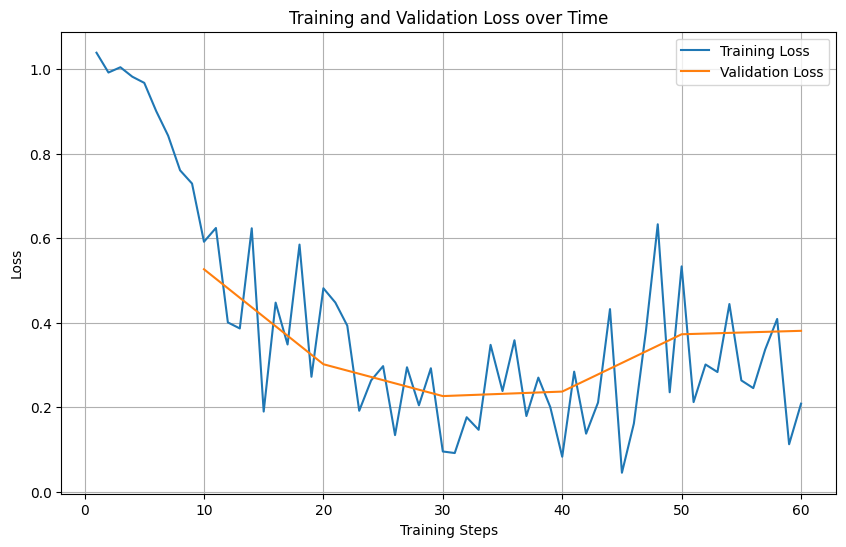

In [62]:
# Access the log history
log_history = trainer.state.log_history

# Convert to a DataFrame for easier handling
logs_df = pd.DataFrame(log_history)

# Filter out rows that contain training loss
train_loss = logs_df[logs_df["loss"].notnull()][["step", "loss"]]

# Filter out rows that contain evaluation loss
eval_loss = logs_df[logs_df["eval_loss"].notnull()][["step", "eval_loss"]]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
model.push_to_hub("terminAl-thesis-2025/deberta-v3-base-terminAl-guard", private=True, token=hf_token)
tokenizer.push_to_hub("terminAl-thesis-2025/deberta-v3-base-terminAl-guard", private=True, token=hf_token)


model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/terminAl-thesis-2025/deberta-v3-base-terminAl-guard/commit/0e5eb69f04ebea40e5d0e3dd7be812961550d5b9', commit_message='Upload tokenizer', commit_description='', oid='0e5eb69f04ebea40e5d0e3dd7be812961550d5b9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/terminAl-thesis-2025/deberta-v3-base-terminAl-guard', endpoint='https://huggingface.co', repo_type='model', repo_id='terminAl-thesis-2025/deberta-v3-base-terminAl-guard'), pr_revision=None, pr_num=None)